# PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS

In [10]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
import warnings
warnings.filterwarnings('ignore')
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression


In [14]:
from google.colab import files


uploaded = files.upload()

Saving forestfires.csv to forestfires.csv


In [35]:
#Loding data
data = pd.read_csv("forestfires.csv")
data

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,large
513,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,large
514,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,large
515,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,small


In [36]:
# dropping encoded columns
raw_data = data[['month', 'day','FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area', 'size_category' ]]
raw_data.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,small


In [37]:
print(data.shape)
print(raw_data.shape)

(517, 31)
(517, 12)


# Descriptive Statistics

In [38]:
raw_data.isna().sum().sum()

0

In [39]:
raw_data.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [40]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [41]:
#Numeric_variables

numeric_features = [feature for feature in raw_data.columns if raw_data[feature].dtypes != 'O']
print('numeric features:', numeric_features, '\n')

numeric features: ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area'] 



In [42]:
#categorical_variables

categorical_features = [feature for feature in raw_data.columns if raw_data[feature].dtypes == 'O']
print('categorical_features:', categorical_features)

categorical_features: ['month', 'day', 'size_category']


In [43]:
#Corrrelation

raw_data.corr()['area'].sort_values(ascending=False)

area    1.000000
temp    0.097844
DMC     0.072994
DC      0.049383
FFMC    0.040122
wind    0.012317
ISI     0.008258
rain   -0.007366
RH     -0.075519
Name: area, dtype: float64

# Visualisation

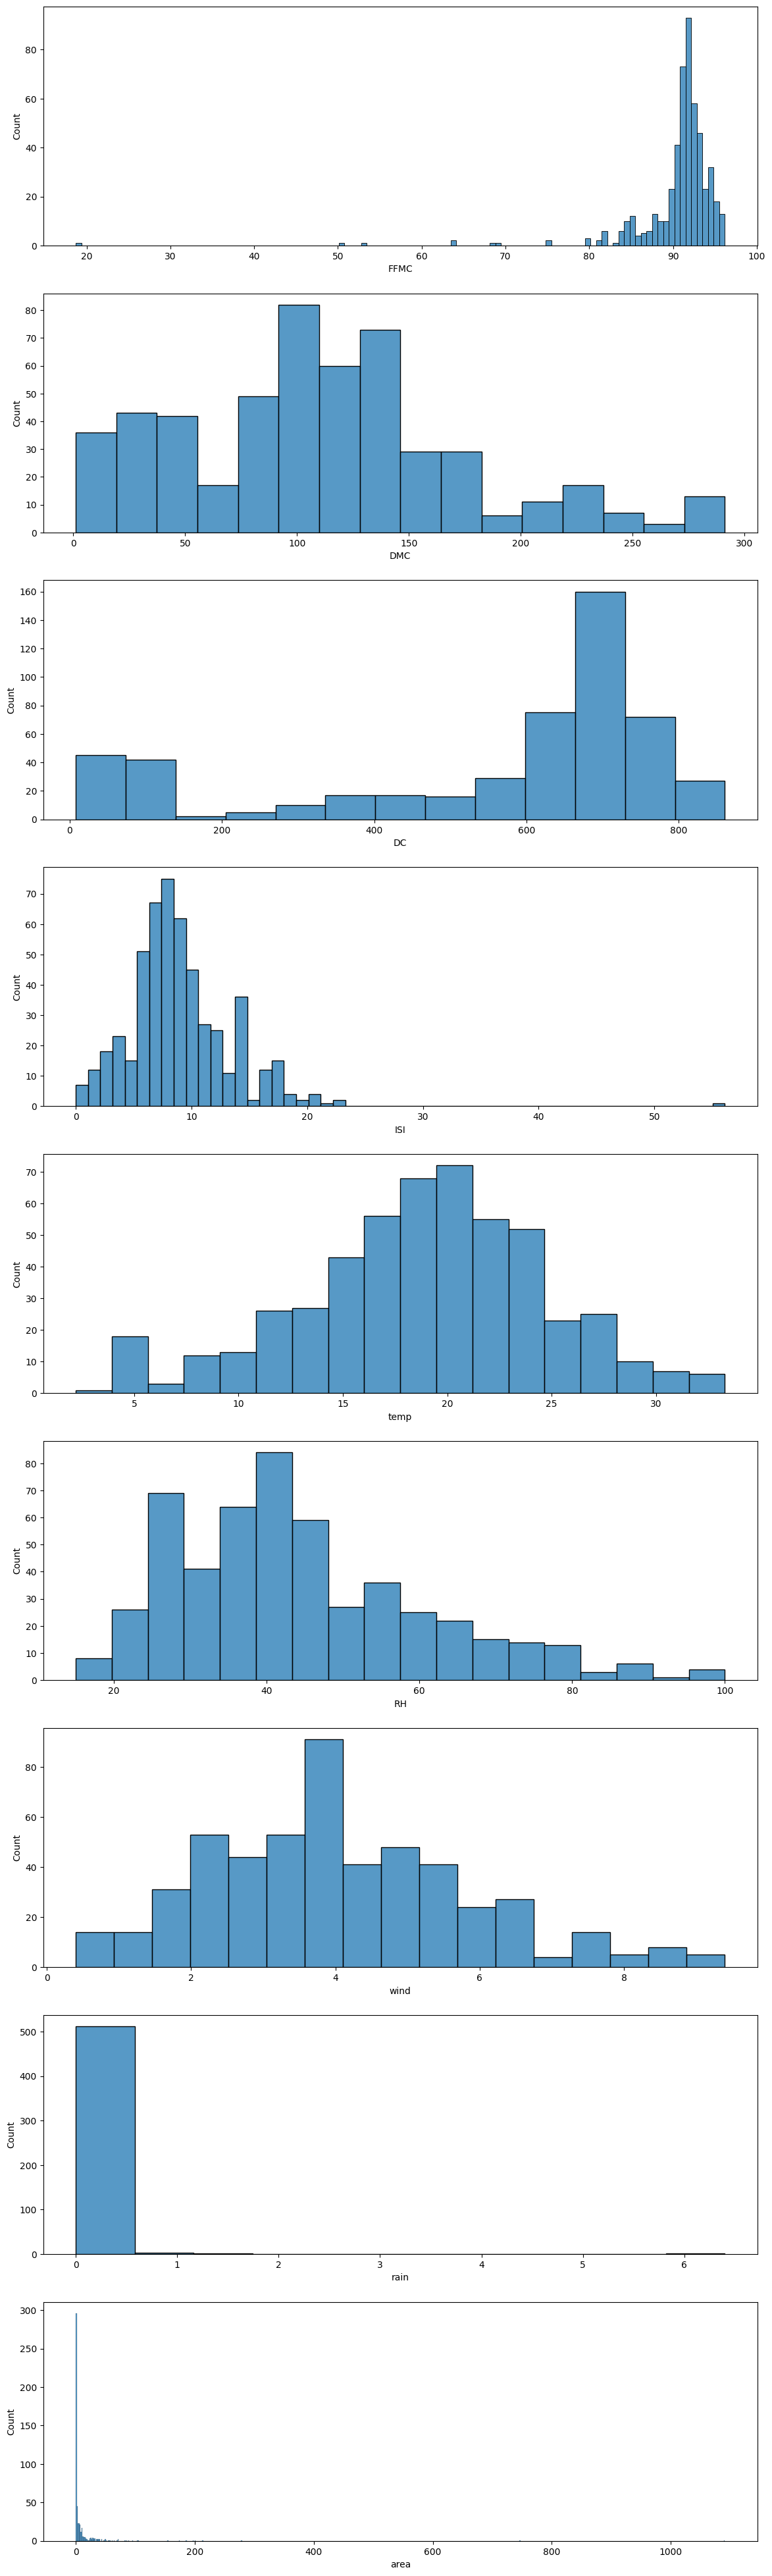

In [44]:
# for numerical_features -- histogram
fig, axes=plt.subplots(len(numeric_features),1,figsize=(14,50))

for i in range (0, len(numeric_features)):
    sns.histplot(data[numeric_features[i]],ax=axes[i])


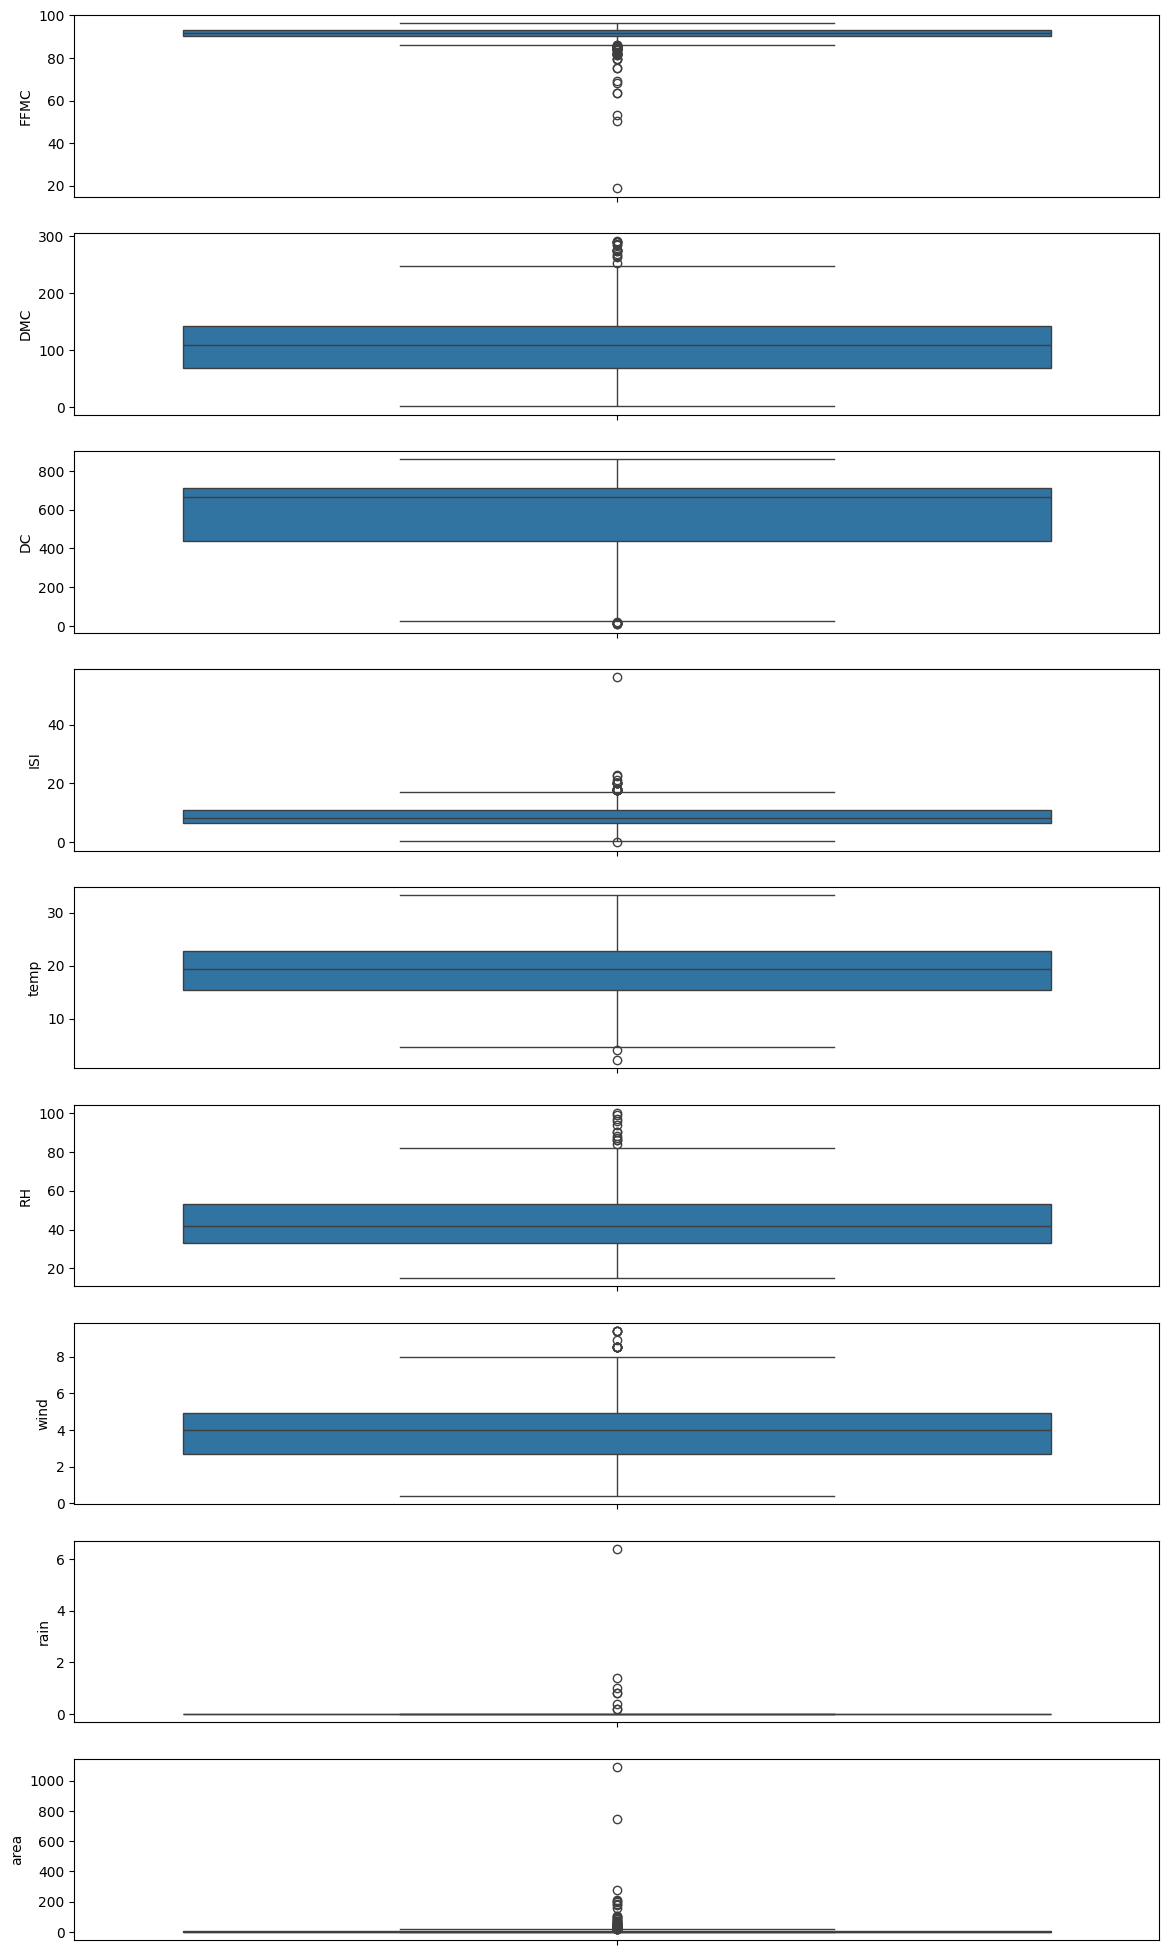

In [45]:
# for outlier detection-- boxplot
fig, axes=plt.subplots(len(numeric_features),1,figsize=(14,25))

for i in range (0, len(numeric_features)):
    sns.boxplot(data[numeric_features[i]],ax=axes[i])


<Axes: >

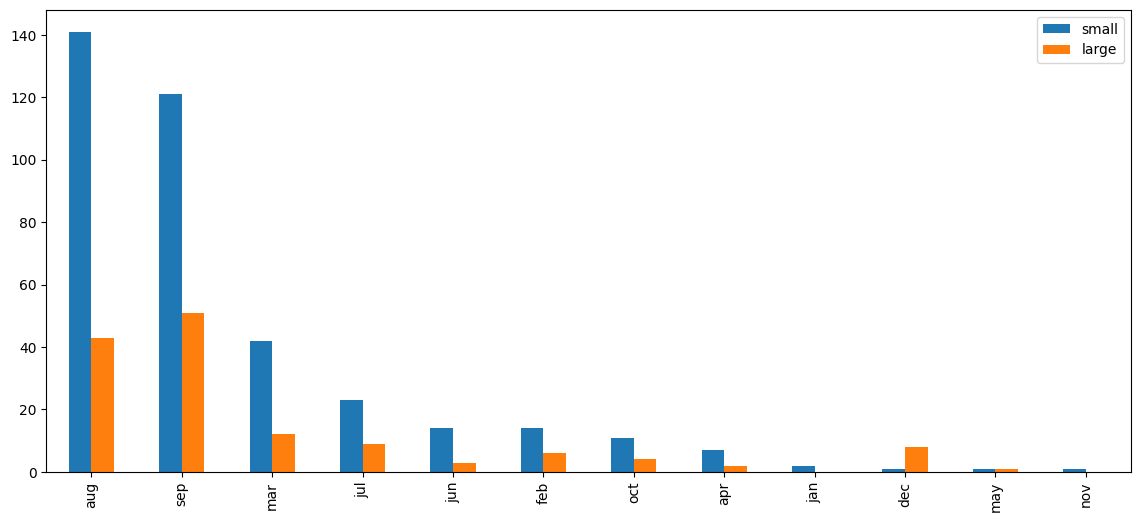

In [46]:
#univariate analysis
# 1) in absolute numbers
df = pd.DataFrame()

df['small'] = raw_data[raw_data['size_category'] == 'small']['month'].value_counts()
df['large'] = raw_data[raw_data['size_category'] == 'large']['month'].value_counts()

df.plot.bar(figsize=(14,6))

<Axes: >

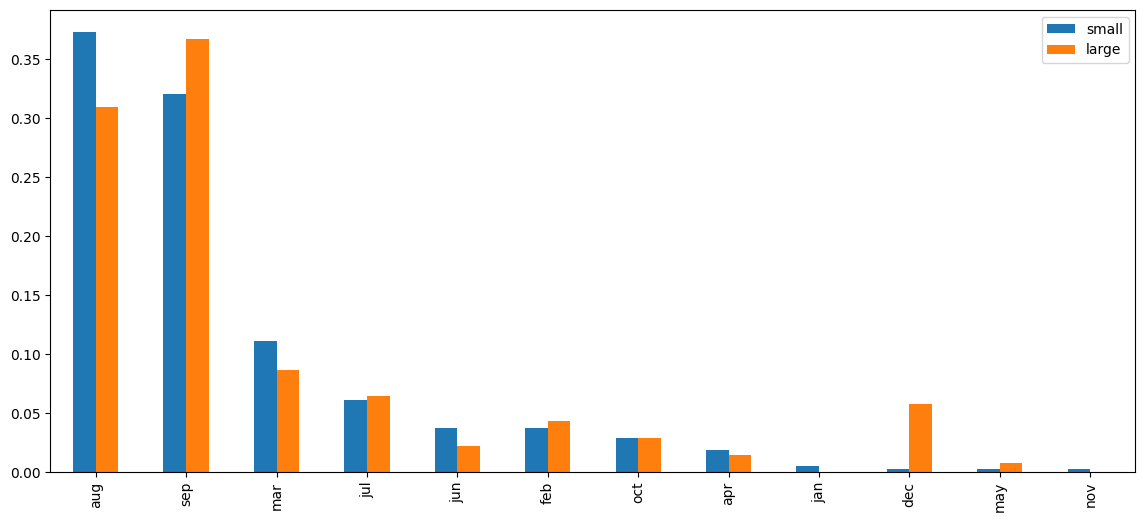

In [47]:
#2) in percentage
df['small'] = raw_data[raw_data['size_category'] == 'small']['month'].value_counts(normalize=True)
df['large'] = raw_data[raw_data['size_category'] == 'large']['month'].value_counts(normalize=True)

df.plot.bar(figsize=(14,6))

# Data Pre-Processing

In [48]:
x = data.copy()
x.drop('size_category',axis=1, inplace =True)

y = data[['size_category']]

In [49]:
# encoding output
le = LabelEncoder()
y = le.fit_transform(y)

# small : 1, large: 0

In [50]:
#inputs are already encoded, just need to drop month and day columns
x.drop(['month' , 'day'] , axis=1, inplace=True)

In [51]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=9)

In [52]:
print("Shape of X_train: ",x_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (361, 28)
Shape of X_test:  (156, 28)
Shape of y_train:  (361,)
Shape of y_test (156,)


# Building Model for ANN

In [53]:
model = Sequential()
model.add(Dense(32,input_dim=28,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(96,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(96,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(96,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

In [54]:
adam=Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',optimizer = adam,metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=20, validation_split=0.3, epochs = 100, verbose=-1)


Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [55]:
pred = model.predict(x_test)

5/5 [==============================] - 0s 2ms/step


In [56]:
pred[:5] # model predicted output in the form of probability

array([[9.9928951e-01],
       [4.8104697e-03],
       [9.9999666e-01],
       [9.9999690e-01],
       [1.6511613e-25]], dtype=float32)

In [57]:
predicted = []
for i in range(0, len(pred)):
    if pred[i]<0.5: #converting prob into 1 or 0
        predicted.append(0)
    else:
        predicted.append(1)

In [58]:
print('actual y is :', y_test[:5] ,'\n', 'predicted y is:', predicted[:5])

actual y is : [1 0 1 1 0] 
 predicted y is: [1, 0, 1, 1, 0]


In [59]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predicted)
print('Accuracy of model is:', accuracy)

Accuracy of model is: 0.9807692307692307


In [60]:
from sklearn.metrics import confusion_matrix , classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        45
           1       0.99      0.98      0.99       111

    accuracy                           0.98       156
   macro avg       0.97      0.98      0.98       156
weighted avg       0.98      0.98      0.98       156



<Axes: >

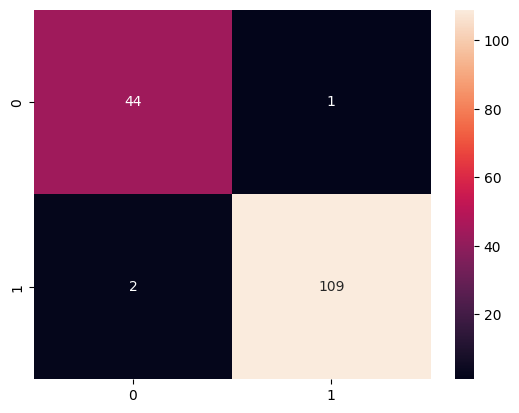

In [61]:
sns.heatmap(confusion_matrix(y_test, predicted), annot=True, fmt='d')